# Tehtävä 4 - Bayes
Hannu Karstu - TTV19SAI

- Avaa Moodlesta löytyvä dokumentti Machine learning fundamentals, Chapter 4, Supervised learning algorithms, Predict Annual Income.pdf
- Tee dokumentissa ohjeistettu esikäsittely Census Income datasetille 
- Dokumentissa on esitelty Naiivi bayes-luokittelija, päätöksentekopuu sekä tukivektorikone SVM sekä esimerkit kuhunkin liittyen.
- Tutustu kuhunkin luokittelijaan ja käy esimerkit läpi
- Dokumentissa on kolme tehtävää: activity 11, activity 12 ja activity 13. Tee tehtävät samaan Jupyter Notebookiin. 
- Hyödynnä Scikit-learnin työkaluja (mm. Grid Search CV) hakeaksesi parhaan mahdollisen suorituskyvyn mallille
- Kommentoi koodisi kattavasti

## 1. Esikäsittely Census Income datasetille
- Avaa Moodlesta löytyvä dokumentti Machine learning fundamentals, Chapter 4, Supervised learning algorithms, Predict Annual Income.pdf
- Tee dokumentissa ohjeistettu esikäsittely Census Income datasetille 

### 1.1 Ladataan data pandasilla
- CSV-tiedosto on jo etukäteen muokattu lisäämällä otsikot ja korvaamalla ?-merkit tyhjällä

In [1]:
import pandas as pd

df=pd.read_csv('teht4_data.csv', sep=',')

df

df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


### 1.2 Tiputetaan tarpeettomat sarakkeet

In [2]:
df = df.drop(['fnlwgt','education','relationship','race','sex'], axis=1)

df.head(3)

,age,workclass,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,0,0,40,United-States,<=50K


### 1.3 Tarkistetaan tyhjät arvot

In [3]:
df.isna().sum()

age                  0
workclass         1836
education-num        0
marital-status       0
occupation        1843
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

- Näitä ei pidä tehtävänannon mukaan tiputtaa pois

### 1.4 Muunnetaan kaikki numeerisiksi arvoiksi

In [4]:
# Tarkistetaan ensin mitä pitää muuttaa
# Muunnetaan kaikki mitkä ei ole int64-muodossa
print(df.dtypes)
df.head(1)

age                int64
workclass         object
education-num      int64
marital-status    object
occupation        object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


,age,workclass,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,2174,0,40,United-States,<=50K


In [5]:
# Otetaan listalle kaikki kolumnien nimet, joiden datatyyppi on object
mylist = list(df.select_dtypes(include=['object']).columns)
mylist

['workclass', 'marital-status', 'occupation', 'native-country', 'income']

In [6]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

# Käydään läpi äsken luotu lista ja muunnetaan oikeat kolumnit numeroarvoiksi
for i in mylist:
    df[i] = pd.Series(enc.fit_transform(df[i].astype('str')))
    
df.head(1)

,age,workclass,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,13,4,0,2174,0,40,38,0


### 1.5 Tarkastetaan outlierit

In [7]:
# Otetaan kaikki kolumnit listalle
allcolumns = df.columns.tolist()
outliers_list = []

# Käsitellään outlierit joka kolumnille
for column in allcolumns:
    min_val = df[column].mean() - (3 * df[column].std())
    max_val = df[column].mean() + (3 * df[column].std())
    outliers = df[column][df[column] > max_val]
    outliers_list.append((column,outliers.count()))

# Printataan lista
print("Sum of outliers in columns:")    
for line in outliers_list:
    print("  ",line[0],"-",line[1])
    
# Tarkistetaan vielä dataframen koko
df.shape

Sum of outliers in columns:
   age - 121
   workclass - 0
   education-num - 0
   marital-status - 0
   occupation - 0
   capital-gain - 215
   capital-loss - 1470
   hours-per-week - 349
   native-country - 0
   income - 0


(32561, 10)

## 2. Esimerkit ja tehtävänanto
- Dokumentissa on esitelty Naiivi bayes-luokittelija, päätöksentekopuu sekä tukivektorikone SVM sekä esimerkit kuhunkin liittyen.
- Tutustu kuhunkin luokittelijaan ja käy esimerkit läpi
- Dokumentissa on kolme tehtävää: activity 11, activity 12 ja activity 13. Tee tehtävät samaan Jupyter Notebookiin.

## 3. Naiivi Bayes -tehtävä (activity 11)


### 3.1 Luodaan ominaisuusmatriisi ja kohdevektori
- Using the preprocessed Census Income Dataset, separate the features from the target by creating the variables X and Y.

In [8]:
# Erotetaan viimeinen kolumni kohdevektoriksi
X = df.iloc[:,:9]
y = df.iloc[:,9]

### 3.2 Jaa testi- ja treenidataan
- Divide the dataset into training, validation, and testing sets, using a split ratio of 10%.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Ymmärsin tehtävänannon "using a split ratio of 10%", siten
# että otetaan 10 % testiin ja 10 % validointiin
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# Train = 80% kokonaisdatasta
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# Test = 10% kokonaisdatasta
# Validation = 10% kokonaisdatasta
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


# Tarkistetaan vielä että jako meni oikein
print("X_train", round(X_train.shape[0]/X.shape[0], 2))
print("X_test", round(X_test.shape[0]/X.shape[0], 2))
print("X_val", round(X_val.shape[0]/X.shape[0], 2))

X_train 0.8
X_test 0.1
X_val 0.1


### 3.3 Ota käyttöön Gaussian Naive Bayes
- Import the Gaussian Naïve Bayes class, and then use the fit method to train the model over the training sets (X_train and Y_train).

In [10]:
from sklearn.naive_bayes import GaussianNB
model_bayes = GaussianNB()
model_bayes.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### 3.4 Luo ennuste
- Finally, perform a prediction using the model that you trained previously, for a new instance with the following values for each feature: 39, 6, 13, 4, 0, 2174, 0, 40, 38.
- The prediction for the individual should be equal to zero, meaning that the individual most likely has an income less than or equal to 50K.

In [11]:
pred = model_bayes.predict([[39, 6, 13, 4, 0, 2174, 0, 40, 38]])
print(pred)

[0]


- Hommahan toimii :)

## 4. Decision Tree Model (activity 12)

### 4.1 Otetaan Decision Tree käyttöön
- Using the preprocessed Census Income Dataset that was previously split into different subsets, import the DecisionTreeClassifier class, and then use the fit method to train the model on the training sets (X_train and Y_train).

In [12]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### 4.2 Luodaan ennuste
- Finally, perform a prediction by using the model that you trained before for a new instance with the following values for each feature: 39, 6, 13, 4, 0, 2174, 0, 40, 38.
- The prediction for the individual should be equal to zero, meaning that the individual most likely has an income less than, or equal to 50K.

In [13]:
pred_dt = model_dt.predict([[39, 6, 13, 4, 0, 2174, 0, 40, 38]])
print(pred_dt)

[0]


## 5. Support Vector Machine Algorithm (activity 13)

### 5.1 Otetaan SVC käyttöön

In [14]:
from sklearn.svm import SVC

model_svc = SVC()
model_svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 5.2 Luodaan ennuste
- Finally, perform a prediction using the model that you trained previously, for a new instance with the following values for each feature: 39, 6, 13, 4, 0, 2174, 0, 40, 38.
- The prediction for the individual should be equal to zero, that is, the individual most likely has an income less than or equal to 50K.

In [15]:
pred_svc = model_svc.predict([[39, 6, 13, 4, 0, 2174, 0, 40, 38.]])
print(pred_svc)

[0]


## 6. Haetaan paras suorituskyky malleille
- Hyödynnä Scikit-learnin työkaluja (mm. Grid Search CV) hakeaksesi parhaan mahdollisen suorituskyvyn mallille

### 6.1 Kokeillaan ensin classification reporttia ja confusion matrixia
- Ajetaan testi yllä olevalle SVC:lle

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

prediction = model_svc.predict(X_test)

print(classification_report(y_test,prediction))
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2451
           1       0.75      0.29      0.42       806

    accuracy                           0.80      3257
   macro avg       0.78      0.63      0.65      3257
weighted avg       0.79      0.80      0.77      3257

[[2375   76]
 [ 574  232]]


### 6.2 Kokeillaan gridSearchilla löytää paremmat parametrit

#### **SVC**
- Tämä on todella aikaa vievä ajaa läpi, älä aja turhaan
- Nyt ajettu X_val ja y_val -datalla, koska datamassan koko vaikuttaa niin paljon laskennan nopeuteen

In [17]:
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output

param_grid = {'C': [1, 10], 'gamma': [0.001, 0.01, 1]}

grid_svc = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

grid_svc.fit(X_val,y_val)

clear_output(wait=True) # Tyhjentää ruudun ennen printtausta

grid_svc.best_params_

{'C': 10, 'gamma': 0.001}

#### **Decision Tree**

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth_range = range(1, 10)
leaf_range = range(1,15)

param_grid = dict(max_depth=depth_range, min_samples_leaf=leaf_range)

d_tree = DecisionTreeClassifier()

grid_dt = GridSearchCV(d_tree, param_grid, cv=10, scoring='accuracy')

grid_dt.fit(X_train,y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)

0.8559968423007864
{'max_depth': 8, 'min_samples_leaf': 3}


#### **Naiivi Bayes**

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

bayes = GaussianNB()

param_grid = {'var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}

grid_bayes = GridSearchCV(bayes,param_grid,refit = True, verbose=2)

grid_bayes.fit(X_train,y_train)

clear_output(wait=True) # Tyhjentää ruudun ennen printtausta
print(grid_bayes.best_params_)

{'var_smoothing': 1e-08}


### 6.4 Luodaan testifunktio

In [36]:
# Original = luokitin ilman gridSearchia
# gridSearched = gridSearchilla tehty
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

# Annetaan X ja y parametreina, jotta voidaan ajaa myös validointidatalla
def fitAndCompare(original,gridSearched,X_train,y_train):
    # Ensin mallin sovitus
    original.fit(X_train,y_train) 
    gridSearched.fit(X_train,y_train)
    
    # Sitten ennuste
    original_pred = original.predict(X_test)
    gridSearched_pred = gridSearched.predict(X_test)
    
    # Sitten tarkkuus-score
    original_acc = accuracy_score(y_test, original_pred)
    gridSearched_acc = accuracy_score(y_test, gridSearched_pred)
    
    # Mallin nimi
    model_name = type(original).__name__
    
    # Lopuksi tuloste ja tarkkuuden laskeminen
    clear_output(wait=True) # Tyhjentää ruudun ennen printtausta
    print(model_name,"accuracy score")
    print("Original:",round(original_acc, 2)*100,"%")
    print("gridSearched:",round(gridSearched_acc, 2)*100,"%")  
    print("")
    
    orig_score = round(original_acc, 2)*100
    grid_score = round(gridSearched_acc, 2)*100
    
    return orig_score, grid_score

### 6.5 Ajetaan testi- ja vertailufunktio jokaiselle

In [22]:
# Decision Tree
fitAndCompare(model_dt,grid_dt,X_train,y_train)

DecisionTreeClassifier accuracy score
Original: 81.0 %
gridSearched: 84.8 %



(81.0, 84.8)

In [23]:
# SVC
fitAndCompare(model_svc,grid_svc,X_val,y_val)

SVC accuracy score
Original: 79.80000000000001 %
gridSearched: 83.3 %



(79.80000000000001, 83.3)

In [24]:
# Naive Bayes
fitAndCompare(model_bayes,grid_bayes,X_train,y_train)

GaussianNB accuracy score
Original: 79.60000000000001 %
gridSearched: 79.5 %



(79.60000000000001, 79.5)

## 7. Testataan pipeline-menetelmää

### 7.1. Importit

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### 7.2 Testifunktio

In [26]:
def pipelineFitandScore(original,gridSearched,X_train,y_train):
    
    # Mallin nimi
    model_name = type(original).__name__
    
    # Muodostetaan pipeline
    pipe_orig = Pipeline([('scaler', StandardScaler()), 
                          (model_name, original)])
    
    pipe_grid = Pipeline([('scaler', StandardScaler()), 
                      ('gridSearchCV', gridSearched)])
    
    # Fitataan
    pipe_orig.fit(X_train, y_train)
    pipe_grid.fit(X_train, y_train)
    
    # Scoren tulostus
    clear_output(wait=True) # Tyhjentää ruudun ennen printtausta
    print(model_name,"accuracy score")
    print("Original",round(pipe_orig.score(X_test, y_test),2)*100,"%")
    print("gridSearched",round(pipe_grid.score(X_test, y_test),2)*100,"%")

In [27]:
pipelineFitandScore(model_bayes,grid_bayes,X_train,y_train)

GaussianNB accuracy score
Original 80.0 %
gridSearched 80.0 %


In [28]:
# Taas käytetään validointidataa SVC:n kanssa
pipelineFitandScore(model_svc,grid_svc,X_val,y_val)

SVC accuracy score
Original 83.0 %
gridSearched 83.0 %


In [29]:
pipelineFitandScore(model_dt,grid_dt,X_train,y_train)

DecisionTreeClassifier accuracy score
Original 81.0 %
gridSearched 85.0 %


## 8. Visualisoidaan tuloksia

### 8.1 Hankitaan visualisointia varten testitulokset

In [37]:
import matplotlib.pyplot as plt

# Ajetaan testit vielä kerran läpi jotta saadaan scoret ylös muuttujiin
dt_score_orig, dt_score_grid = fitAndCompare(model_dt,grid_dt,X_train,y_train)
svc_score_orig, svc_score_grid = fitAndCompare(model_svc,grid_svc,X_val,y_val)
bayes_score_orig, bayes_score_grid = fitAndCompare(model_bayes,grid_bayes,X_train,y_train)


GaussianNB accuracy score
Original: 80.0 %
gridSearched: 79.0 %



In [38]:
# Lisätään scoret listaan
scoresList = [dt_score_orig, dt_score_grid, svc_score_orig, svc_score_grid,bayes_score_orig, bayes_score_grid]
print(scoresList)

[81.0, 85.0, 80.0, 83.0, 80.0, 79.0]


### 8.2 Visualisoidaan testitulokset pylväsdiagrammina

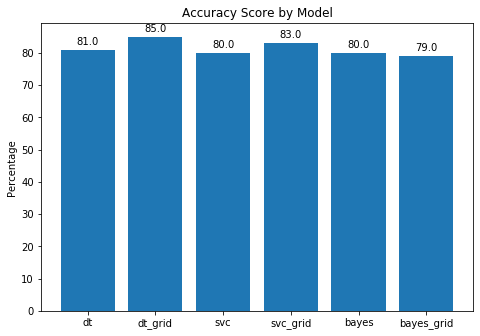

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Percentage')
ax.set_title('Accuracy Score by Model')

models = ['dt','dt_grid','svc', 'svc_grid', 'bayes','bayes_grid']
rects = ax.bar(models,scoresList)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()

## Arviointi

- [x] Taso 1: olet tehnyt yhden kolmesta (1/3) aktiviteetista (activity 11, 12, 13) dokumentoidusti

- [x] Taso 2: olet tehnyt kaksi kolmesta (2/3) aktiviteetista (activity 11, 12, 13) dokumentoidusti

- [x] Taso 3: olet edellisen lisäksi implementoinut gridsearchCV -algoritmin koodisi

- [x] Taso 4: olet edellisten lisäksi käyttänyt pipeline menetelmää ja grid searchia optimoidaksesi algoritmit

- [x] Taso 5: olet edellisten lisäksi visualisoinut jollakin menetelmällä luokittelun onnistumista